In [69]:
import pandas as pd
from glob import glob
import os
import warnings

In [70]:
# Collect and parse data.

DATA_PATH = './data'
data_ext = '*.csv'

search_path = os.path.join(DATA_PATH, data_ext)
filenames = glob(search_path)
assert filenames, 'No files found matching pattern {}.'.format(
    os.path.abspath(search_path)
)

scales = ['Busy', 'Fused', 'Kaleidoscopic']
method = 'spearman'

orig, stat, spec = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for file in filenames:
    df = pd.read_csv(file)

    # Parse data with a warning message in first row.
    if df.columns.size == 1:
        warnings.warn(
            'File {} is flagged. Skipping first row...'.format(
                os.path.basename(file)
            )
        )
        df = pd.read_csv(file, skiprows=1)

    orig = orig.append(df[df['type'] == 'O'])
    stat = stat.append(df[df['type'] == '32R'])
    spec = spec.append(df[df['type'] == 'S'])

orig = orig.reset_index(drop=True)
stat = stat.reset_index(drop=True)
spec = spec.reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: File 0028.20210208.5fe798172fd45c14e596930d.csv is flagged. Skipping first row...


### Data analysis TODO:

1. Calculate correlations per subject, then average correlations.
2. ALSO, average ratings across subjects, then computer correlations.
   e.g. AVERAGE ALL RATINGS between subjects, then computer one correlation.
 
3. Do both spearman and pearson. In both cases, also do r**2. (square before
      averaging).

4. how does this break down per stimulus?
    - groups: orig, resynth, spectral (20 * 3 = 60 stimuli)
    - for each stimulus, calculate correlation between re-syntheses. (analysis level, statistical power not important at this juncture).

In [71]:
def ave_corr(df, method, r2=False):
    """Correlations from averaging ratings over each stimulus."""
    tmp = df.groupby(df['stimNo']).mean()
    
    if r2:
        tmp = tmp ** 2
    
    return tmp[scales].corr(method=method)

def ave_corrwith(df1, df2, method, r2=False):
    """Cross-scale correlations from averaging ratings over each stimulus."""
    tmp1 = df1.groupby(df1['stimNo']).mean()
    tmp1 = tmp1.reset_index()[scales]
    
    tmp2 = df2.groupby(df2['stimNo']).mean()
    tmp2 = tmp2.reset_index()[scales]
    
    return tmp1.corrwith(tmp2, method=method)


def subject_corr(df1, method, r2=False):
    """Internal subjects scale correlations. Correlations are averaged across subjects."""
    tmp = df[scales].groupby(df['participant']).corr(method=method)
    
    if r2:
        tmp = tmp ** 2
    
    return tmp.mean(level=1)

def subject_corrwith(df1, df2, method, r2=False):
    """Internal subjects cross-scale correlations. Correlations are averaged across subjects."""
    tmp = pd.DataFrame()
    
    grouped1 = df1[scales].groupby(df1['participant'])
    grouped2 = df2[scales].groupby(df2['participant'])

    for (participant_no, ratings1), (_, ratings2) in zip(grouped1, grouped2):
        tmp[participant_no] = ratings1.corrwith(ratings2, method=method)
        
    if r2:
        tmp = tmp ** 2

    return tmp.mean(axis=1)

Busy             0.321466
Fused            0.170662
Kaleidoscopic    0.233556
dtype: float64

,Busy,Fused,Kaleidoscopic
Busy,1.000000,-0.435965,0.455399
Fused,-0.435965,1.000000,-0.435945
Kaleidoscopic,0.455399,-0.435945,1.000000


Busy             0.765680
Fused           -0.182910
Kaleidoscopic    0.215894
dtype: float64

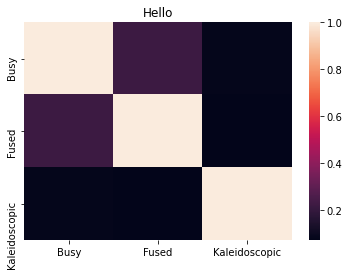

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

r2 = False
method='pearson'

plt.title('Hello')
sns.heatmap(subject_corr(orig, method, r2=r2))
display(subject_corrwith(orig, spec, method, r2=r2))

display(ave_corr(orig, method, r2=r2))
display(ave_corrwith(orig, spec, method, r2=r2))


In [68]:
# df1 = orig
# df2 = stat
# method = 'pearson'


# tmp1 = df1.groupby(df1['stimNo']).mean()
# tmp2 = df2.groupby(df2['stimNo']).mean()
    
# tmp1[scales].reset_index().corrwith(tmp2[scales].reset_index(), method=method)

stimNo           1.000000
Busy             0.854850
Fused            0.279197
Kaleidoscopic    0.726341
dtype: float64

In [74]:
# Old statistics (for comparison to new methods only, not valid)...

print('\nOriginal excerpts...')
print(orig[scales].corr(method=method))

print('\nStatistical resynth...')
print(stat[scales].corr(method=method))

print('\nSpectral resynth...')
print(spec[scales].corr(method=method))

print('\nOriginal corr. Statistics')
print(orig[scales].corrwith(stat[scales], method=method))

print('\nOriginal corr. Spectral')
print(orig[scales].corrwith(spec[scales], method=method))


Original excerpts...
                   Busy     Fused  Kaleidoscopic
Busy           1.000000 -0.076543       0.171798
Fused         -0.076543  1.000000      -0.053558
Kaleidoscopic  0.171798 -0.053558       1.000000

Statistical resynth...
                   Busy     Fused  Kaleidoscopic
Busy           1.000000 -0.004254       0.200413
Fused         -0.004254  1.000000       0.007080
Kaleidoscopic  0.200413  0.007080       1.000000

Spectral resynth...
                   Busy     Fused  Kaleidoscopic
Busy           1.000000  0.009279       0.085947
Fused          0.009279  1.000000       0.036259
Kaleidoscopic  0.085947  0.036259       1.000000

Original corr. Statistics
Busy             0.494088
Fused            0.464473
Kaleidoscopic    0.444739
dtype: float64

Original corr. Spectral
Busy             0.261062
Fused            0.068675
Kaleidoscopic    0.254096
dtype: float64
